# K-Means

In [1]:
import sys
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import psycopg2.extras

root_path = Path().resolve().parent.parent
sys.path.append(str(root_path))

from src.dataset.connection import connect_to_spotify_dataset
from src.dataset.connection import select

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn.functional as F

from sklearn.metrics import silhouette_score, davies_bouldin_score

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import json

In [2]:
connection = connect_to_spotify_dataset(json_file = 'security_details.json') # Add db Password
if not connection:
    print("Connection Error")
tds = select(connection, "SELECT * FROM track_data") 

Connection successful
Connection closed.


In [3]:
columns = [
    "id", "name", "popularity", "duration_ms", "explicit", "artists", "id_artists", "release_date",
    "danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness", 
    "instrumentalness", "liveness", "valence", "tempo", "time_signature","decade", "mood_index", "emotion_index", "party_index", "chill_index"
]
# Create the DataFrame
df = pd.DataFrame(tds, columns=columns)
print(df.dtypes)
df.head()

id                   object
name                 object
popularity            int64
duration_ms           int64
explicit               bool
artists              object
id_artists           object
release_date         object
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                   bool
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature        int64
decade                int64
mood_index          float64
emotion_index       float64
party_index         float64
chill_index         float64
dtype: object


,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,instrumentalness,liveness,valence,tempo,time_signature,decade,mood_index,emotion_index,party_index,chill_index
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,False,[Uli],[45tIt06XoI0Iio4LBEVpls],1922-02-22,0.645,0.445,...,0.744000,0.151,0.127,104.851,3,1920,0.3460,4.1857,0.5450,0.6264
1,2B9d7LBGJvQEKiLEAexCOP,Toda Alma - Remasterizado,0,180253,False,[Ignacio Corsini],[5LiOoJbxVSAMkBS2fUm3X2],1922-03-21,0.545,0.268,...,0.920000,0.112,0.648,126.614,4,1920,0.5411,7.2483,0.4065,0.8898
2,3fKqEoaJZODF7Xhh7qH4Wv,Capítulo 2.10 - Banquero Anarquista,0,106800,False,[Fernando Pessoa],[14jtPCOoNZwquk5wd9DxrY],1922-06-01,0.702,0.200,...,0.000000,0.360,0.773,81.152,4,1920,0.6371,7.2689,0.4510,0.7052
3,3h8ioTTWfrC25hrHwQQpLc,All Or Nothing at All,0,164320,False,"[Dick Haymes, Harry James, His Orchestra]","[3BiJGZsyX9sJchTqcSA7Su, 5MpELOfAiq7aIBTij30ph...",1922,0.237,0.555,...,0.000262,0.366,0.292,92.213,3,1920,0.3281,2.2666,0.3960,0.6652
4,3rcerSJNOkfgB9CELqcRHL,Capítulo 1.5 - Banquero Anarquista,0,108200,False,[Fernando Pessoa],[14jtPCOoNZwquk5wd9DxrY],1922-06-01,0.773,0.155,...,0.000000,0.130,0.494,52.032,4,1920,0.5099,7.6010,0.4640,0.6926


# PCA

In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

selected_columns = ['popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key',
                    'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
                    'liveness', 'valence', 'tempo', 'decade',"mood_index","emotion_index","party_index","chill_index"]

X = df[selected_columns]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

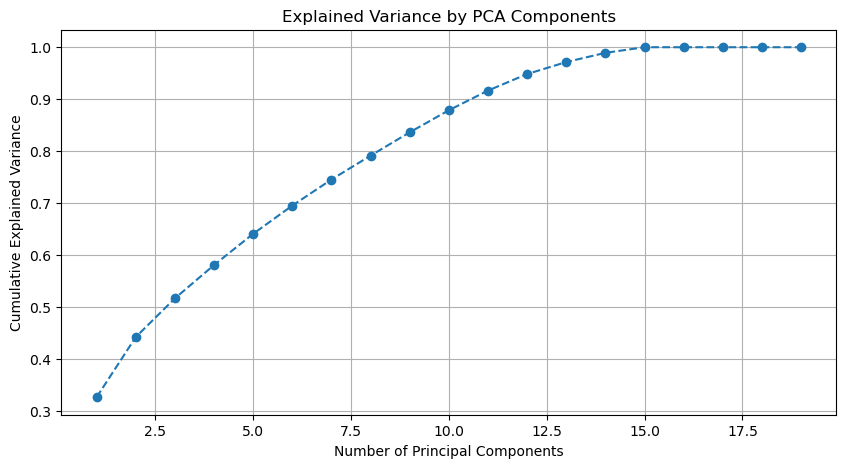

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(selected_columns) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid()
plt.show()

In [6]:
explained_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(explained_variance >= 0.95) + 1  # Get number of components for 95% variance

print(f"Number of components needed to explain 95% variance: {n_components}")

pca_final = PCA(n_components=n_components)
X_pca_final = pca_final.fit_transform(X_scaled)

df_pca = pd.DataFrame(X_pca_final, columns=[f'PC{i+1}' for i in range(n_components)])

Number of components needed to explain 95% variance: 13


In [7]:
df_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13
0,2.850335,-1.142593,-0.139927,1.100900,-0.323914,1.688455,0.170356,-1.619641,0.754358,-1.237909,-1.378983,-1.966582,-0.065796
1,4.782921,-2.613566,-1.382054,-0.410290,0.134007,2.592092,-0.909475,-0.947700,0.534420,-0.317314,0.180578,-0.421906,-0.531435
2,3.471532,-4.868485,2.170714,1.944426,0.935804,1.095645,-0.180937,1.267889,0.375248,-0.003505,-2.083327,-0.161148,-0.955737
3,2.316427,0.526614,-1.255247,1.979627,0.264365,-1.790033,1.217926,-2.442833,-0.609599,-0.205432,-0.959742,0.523042,-0.839259
4,3.984604,-4.231443,3.109606,0.513646,2.428262,0.627852,0.499387,0.738090,-0.395483,-0.816502,-3.031835,-0.228948,-0.698584
...,...,...,...,...,...,...,...,...,...,...,...,...,...
525582,2.949409,-2.105609,-0.727098,-0.145893,0.817069,-1.026310,0.559714,-1.178877,-0.664751,0.140513,-0.887888,0.888050,-0.785680
525583,2.832162,-4.926818,1.329689,2.106337,-0.360467,1.185493,-0.706966,0.187178,-0.709177,0.634154,-1.774095,-0.997550,-0.955335
525584,3.019127,-4.463060,1.770592,1.931700,-0.401105,1.017625,0.617963,-0.026655,-0.337722,0.280858,-2.190338,-1.275294,-1.046852
525585,3.638911,-2.707100,-1.521952,-1.024173,1.759140,1.117252,0.985322,-2.090713,0.384924,-0.763986,0.576549,-0.069886,-1.383724


In [8]:
# Compute variance of each feature
feature_variance = df[selected_columns].var()

# Sort features by variance (descending order)
feature_variance_sorted = feature_variance.sort_values(ascending=False)

print(feature_variance_sorted)

duration_ms         9.248533e+09
tempo               8.892337e+02
decade              5.233641e+02
popularity          3.352937e+02
loudness            2.599736e+01
key                 1.238093e+01
emotion_index       2.096494e+00
mode                2.252908e-01
acousticness        1.209080e-01
chill_index         8.355716e-02
instrumentalness    7.084767e-02
valence             6.646686e-02
energy              6.337540e-02
explicit            4.300033e-02
speechiness         3.490188e-02
mood_index          3.447737e-02
liveness            3.409099e-02
party_index         2.776405e-02
danceability        2.767026e-02
dtype: float64


# K-Means - SKLearn

In [9]:
df.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,instrumentalness,liveness,valence,tempo,time_signature,decade,mood_index,emotion_index,party_index,chill_index
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,False,[Uli],[45tIt06XoI0Iio4LBEVpls],1922-02-22,0.645,0.445,...,0.744000,0.151,0.127,104.851,3,1920,0.3460,4.1857,0.5450,0.6264
1,2B9d7LBGJvQEKiLEAexCOP,Toda Alma - Remasterizado,0,180253,False,[Ignacio Corsini],[5LiOoJbxVSAMkBS2fUm3X2],1922-03-21,0.545,0.268,...,0.920000,0.112,0.648,126.614,4,1920,0.5411,7.2483,0.4065,0.8898
2,3fKqEoaJZODF7Xhh7qH4Wv,Capítulo 2.10 - Banquero Anarquista,0,106800,False,[Fernando Pessoa],[14jtPCOoNZwquk5wd9DxrY],1922-06-01,0.702,0.200,...,0.000000,0.360,0.773,81.152,4,1920,0.6371,7.2689,0.4510,0.7052
3,3h8ioTTWfrC25hrHwQQpLc,All Or Nothing at All,0,164320,False,"[Dick Haymes, Harry James, His Orchestra]","[3BiJGZsyX9sJchTqcSA7Su, 5MpELOfAiq7aIBTij30ph...",1922,0.237,0.555,...,0.000262,0.366,0.292,92.213,3,1920,0.3281,2.2666,0.3960,0.6652
4,3rcerSJNOkfgB9CELqcRHL,Capítulo 1.5 - Banquero Anarquista,0,108200,False,[Fernando Pessoa],[14jtPCOoNZwquk5wd9DxrY],1922-06-01,0.773,0.155,...,0.000000,0.130,0.494,52.032,4,1920,0.5099,7.6010,0.4640,0.6926


In [10]:
#duration, tempo, decade, popularity, key, emotion index, mode, chill index
df_kmeans = df[['duration_ms', 'tempo', 'decade', 'popularity', 'key', 'emotion_index', 'mode', 'chill_index']]
df_kmeans.head()

,duration_ms,tempo,decade,popularity,key,emotion_index,mode,chill_index
0,126903,104.851,1920,6,0,4.1857,True,0.6264
1,180253,126.614,1920,0,1,7.2483,True,0.8898
2,106800,81.152,1920,0,7,7.2689,True,0.7052
3,164320,92.213,1920,0,2,2.2666,False,0.6652
4,108200,52.032,1920,0,9,7.6010,False,0.6926


In [11]:
#pre-proc
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_kmeans)

In [12]:
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)  #sum of squared distances to cluster center

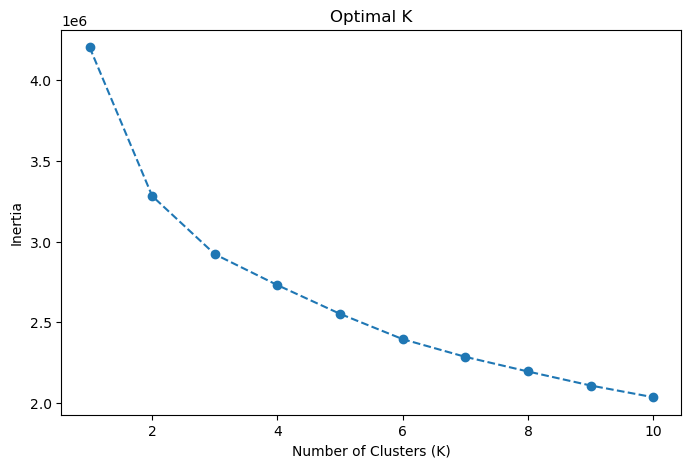

In [13]:
plt.figure(figsize=(8,5))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Optimal K')
plt.show()

In [14]:
optimal_k = 3 
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
#df['Cluster'] = kmeans.fit_predict(df_scaled)

In [15]:
df.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,instrumentalness,liveness,valence,tempo,time_signature,decade,mood_index,emotion_index,party_index,chill_index
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,False,[Uli],[45tIt06XoI0Iio4LBEVpls],1922-02-22,0.645,0.445,...,0.744000,0.151,0.127,104.851,3,1920,0.3460,4.1857,0.5450,0.6264
1,2B9d7LBGJvQEKiLEAexCOP,Toda Alma - Remasterizado,0,180253,False,[Ignacio Corsini],[5LiOoJbxVSAMkBS2fUm3X2],1922-03-21,0.545,0.268,...,0.920000,0.112,0.648,126.614,4,1920,0.5411,7.2483,0.4065,0.8898
2,3fKqEoaJZODF7Xhh7qH4Wv,Capítulo 2.10 - Banquero Anarquista,0,106800,False,[Fernando Pessoa],[14jtPCOoNZwquk5wd9DxrY],1922-06-01,0.702,0.200,...,0.000000,0.360,0.773,81.152,4,1920,0.6371,7.2689,0.4510,0.7052
3,3h8ioTTWfrC25hrHwQQpLc,All Or Nothing at All,0,164320,False,"[Dick Haymes, Harry James, His Orchestra]","[3BiJGZsyX9sJchTqcSA7Su, 5MpELOfAiq7aIBTij30ph...",1922,0.237,0.555,...,0.000262,0.366,0.292,92.213,3,1920,0.3281,2.2666,0.3960,0.6652
4,3rcerSJNOkfgB9CELqcRHL,Capítulo 1.5 - Banquero Anarquista,0,108200,False,[Fernando Pessoa],[14jtPCOoNZwquk5wd9DxrY],1922-06-01,0.773,0.155,...,0.000000,0.130,0.494,52.032,4,1920,0.5099,7.6010,0.4640,0.6926


# K-Means - PyTorch

In [16]:
# Pre-proc: convert to PyTorch tensor
X = torch.tensor(df_scaled, dtype=torch.float32) 

In [17]:
def compute_inertia(X, k_values):
    """
    Computes inertia (sum of squared distances to the nearest centroid) for different values of k.

    Parameters:
    X (torch.Tensor): The dataset containing feature vectors.
    k_values (list): A list of k values to evaluate.

    Returns:
    list: A list of inertia values corresponding to each k.
    """
    inertia = [] 

    for k in k_values:
        # Randomly initialize k cluster centroids
        num_samples = X.shape[0] 
        random_indices = torch.randperm(num_samples)[:k]  # Randomly select k indices
        centroids = X[random_indices]  # Initial centroids

        # Run K-Means iteratively
        for iteration in range(50):  
            # Pairwise distances between data points and centroids
            distances = torch.cdist(X, centroids)  

            # Assign each data point to the nearest centroid
            labels = torch.argmin(distances, dim=1) 

            # Compute new centroids as the mean of assigned points
            new_centroids = []
            for i in range(k):
                cluster_points = X[labels == i]  
                if cluster_points.shape[0] > 0:
                    new_centroid = cluster_points.mean(dim=0) 
                else:
                    new_centroid = centroids[i]  # Keep old centroid if no points assigned
                new_centroids.append(new_centroid)
            
            # Convert list of tensors into a single tensor
            new_centroids = torch.stack(new_centroids)  

            # Check for convergence 
            centroid_shift = torch.norm(new_centroids - centroids)
            if centroid_shift < 1e-4:
                break  

            # Update centroids for the next iteration
            centroids = new_centroids  

        # Compute inertia 
        min_distances, idx_centroid = torch.min(torch.cdist(X, centroids), dim=1)  
        inertia_value = torch.sum(min_distances ** 2).item()  
        inertia.append(inertia_value) 

    return inertia  

In [18]:
k_values = range(1, 11)
inertia_values = compute_inertia(X, k_values)

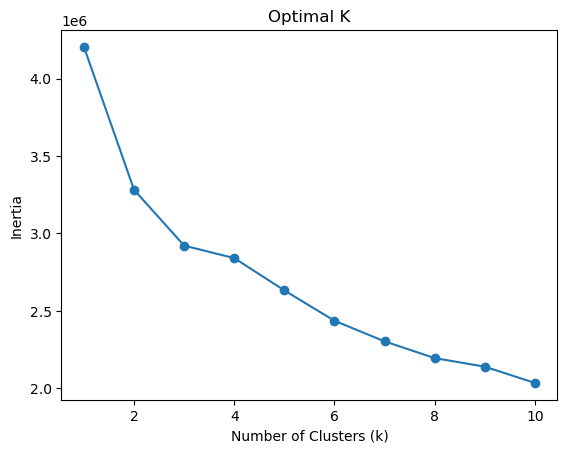

In [19]:
plt.plot(k_values, inertia_values, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Optimal K")
plt.show()

In [20]:
def evaluate_clusters(X, k_values):
    """
    Evaluates different k-values using Silhouette Score and Davies Bouldin Index.

    Parameters:
    X (torch.Tensor): Data points.
    k_values (list): List of k values to evaluate.

    Returns:
    dict: Scores for each k.
    """
    scores = {"davies_bouldin": {}}

    for k in k_values:
        # Initialize k-means with k clusters
        num_samples = X.shape[0]
        random_indices = torch.randperm(num_samples)[:k]
        centroids = X[random_indices]

        # Run K-Means clustering
        for j in range(20):  
            distances = torch.cdist(X, centroids)
            labels = torch.argmin(distances, dim=1)

            new_centroids = []
            for i in range(k):
                cluster_points = X[labels == i]
                if cluster_points.shape[0] > 0:
                    new_centroid = cluster_points.mean(dim=0)
                else:
                    new_centroid = centroids[i]
                new_centroids.append(new_centroid)

            new_centroids = torch.stack(new_centroids)
            if torch.norm(new_centroids - centroids) < 1e-4:
                break

            centroids = new_centroids

        # Compute DBI
        labels_np = labels.numpy()
        X_np = X.numpy()

        dbi = davies_bouldin_score(X_np, labels_np) if k > 1 else float("inf")  # Higher k means more separation

        scores["davies_bouldin"][k] = dbi

        print(f"k={k}: Davies-Bouldin Index = {dbi:.4f}")

    return scores


In [21]:
k_values = range(2, 11)  
scores = evaluate_clusters(X, k_values)

k=2: Davies-Bouldin Index = 1.7870
k=3: Davies-Bouldin Index = 2.2024
k=4: Davies-Bouldin Index = 2.0887
k=5: Davies-Bouldin Index = 2.1203
k=6: Davies-Bouldin Index = 2.0648
k=7: Davies-Bouldin Index = 2.0317
k=8: Davies-Bouldin Index = 1.7271
k=9: Davies-Bouldin Index = 1.7281
k=10: Davies-Bouldin Index = 1.7631


In [22]:
k = 8
max_iters = 100  
tol = 1e-4 

# Randomly initialize cluster centroids
num_samples = X.shape[0]  
random_indices = torch.randperm(num_samples)[:k]  
centroids = X[random_indices]  

# K-Means 
for iteration in range(max_iters):  
    print(f"Iteration {iteration + 1}") 

    # Compute distances between each data point and centroid
    distances = torch.cdist(X, centroids)  

    # Assign each data point to the nearest centroid
    labels = torch.argmin(distances, dim=1)  

    # Compute new centroids by averaging all points assigned to each cluster
    new_centroids = []  

    for cluster_id in range(k):
        cluster_points = X[labels == cluster_id]  

        if cluster_points.shape[0] > 0:  
            new_centroid = cluster_points.mean(dim=0)
        else:
            new_centroid = centroids[cluster_id]  

        new_centroids.append(new_centroid)  

    new_centroids = torch.stack(new_centroids)  

    # Check for convergence
    centroid_shift = torch.norm(new_centroids - centroids)  
    print(f"Centroid shift: {centroid_shift:.6f}") 

    if centroid_shift < tol:  
        break  

    # Update centroids for the next iteration
    centroids = new_centroids

df["cluster"] = labels.numpy()  

Iteration 1
Centroid shift: 2.896750
Iteration 2
Centroid shift: 1.112538
Iteration 3
Centroid shift: 0.738266
Iteration 4
Centroid shift: 0.611335
Iteration 5
Centroid shift: 0.511824
Iteration 6
Centroid shift: 0.406661
Iteration 7
Centroid shift: 0.327118
Iteration 8
Centroid shift: 0.265589
Iteration 9
Centroid shift: 0.210777
Iteration 10
Centroid shift: 0.161988
Iteration 11
Centroid shift: 0.120739
Iteration 12
Centroid shift: 0.097776
Iteration 13
Centroid shift: 0.077254
Iteration 14
Centroid shift: 0.065081
Iteration 15
Centroid shift: 0.056667
Iteration 16
Centroid shift: 0.051471
Iteration 17
Centroid shift: 0.048131
Iteration 18
Centroid shift: 0.043571
Iteration 19
Centroid shift: 0.042144
Iteration 20
Centroid shift: 0.039424
Iteration 21
Centroid shift: 0.038887
Iteration 22
Centroid shift: 0.037329
Iteration 23
Centroid shift: 0.039223
Iteration 24
Centroid shift: 0.039988
Iteration 25
Centroid shift: 0.040085
Iteration 26
Centroid shift: 0.041483
Iteration 27
Centroid

In [23]:
labels_dict = df["cluster"].to_dict()

with open("kmeans_cluster_labels.json", "w") as f:
    json.dump(labels_dict, f)

In [24]:
df['cluster'].unique()

array([3, 5, 2, 0, 7, 4, 1, 6])

In [25]:
df['cluster'].value_counts()

cluster
6    108505
1     85016
4     74976
7     70053
5     62260
3     57353
2     52060
0     15364
Name: count, dtype: int64

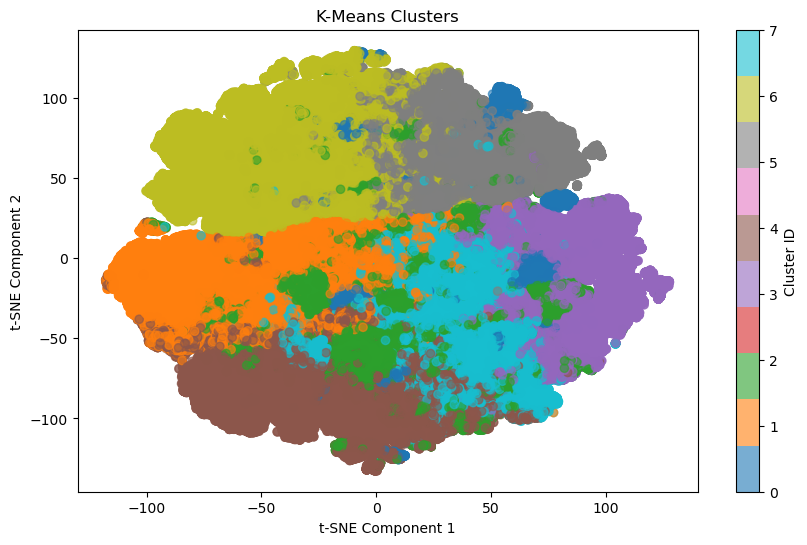

In [26]:
#reduce dimensions to 2D using t-SNE for visualization
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_2d = tsne.fit_transform(X.numpy())  #convert tensor to NumPy

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=df["cluster"], cmap="tab10", alpha=0.6)
plt.colorbar(scatter, label="Cluster ID")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("K-Means Clusters")
plt.show()

# K-Means (PCA) - PyTorch

In [27]:
df_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13
0,2.850335,-1.142593,-0.139927,1.100900,-0.323914,1.688455,0.170356,-1.619641,0.754358,-1.237909,-1.378983,-1.966582,-0.065796
1,4.782921,-2.613566,-1.382054,-0.410290,0.134007,2.592092,-0.909475,-0.947700,0.534420,-0.317314,0.180578,-0.421906,-0.531435
2,3.471532,-4.868485,2.170714,1.944426,0.935804,1.095645,-0.180937,1.267889,0.375248,-0.003505,-2.083327,-0.161148,-0.955737
3,2.316427,0.526614,-1.255247,1.979627,0.264365,-1.790033,1.217926,-2.442833,-0.609599,-0.205432,-0.959742,0.523042,-0.839259
4,3.984604,-4.231443,3.109606,0.513646,2.428262,0.627852,0.499387,0.738090,-0.395483,-0.816502,-3.031835,-0.228948,-0.698584
...,...,...,...,...,...,...,...,...,...,...,...,...,...
525582,2.949409,-2.105609,-0.727098,-0.145893,0.817069,-1.026310,0.559714,-1.178877,-0.664751,0.140513,-0.887888,0.888050,-0.785680
525583,2.832162,-4.926818,1.329689,2.106337,-0.360467,1.185493,-0.706966,0.187178,-0.709177,0.634154,-1.774095,-0.997550,-0.955335
525584,3.019127,-4.463060,1.770592,1.931700,-0.401105,1.017625,0.617963,-0.026655,-0.337722,0.280858,-2.190338,-1.275294,-1.046852
525585,3.638911,-2.707100,-1.521952,-1.024173,1.759140,1.117252,0.985322,-2.090713,0.384924,-0.763986,0.576549,-0.069886,-1.383724


In [28]:
# Pre-proc: convert to PyTorch tensor
X = torch.tensor(df_pca.to_numpy(), dtype=torch.float32) 

In [39]:
k_values = range(1, 11)
inertia_values = compute_inertia(X, k_values)

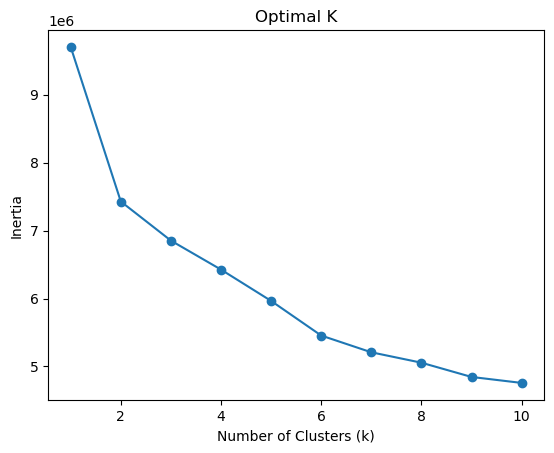

In [40]:
plt.plot(k_values, inertia_values, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Optimal K")
plt.show()

In [41]:
k_values = range(2, 11)  
scores = evaluate_clusters(X, k_values)

k=2: Davies-Bouldin Index = 1.7043
k=3: Davies-Bouldin Index = 2.1301
k=4: Davies-Bouldin Index = 1.8826
k=5: Davies-Bouldin Index = 1.9666
k=6: Davies-Bouldin Index = 1.8788
k=7: Davies-Bouldin Index = 1.7577
k=8: Davies-Bouldin Index = 1.9304
k=9: Davies-Bouldin Index = 1.8853
k=10: Davies-Bouldin Index = 1.8531


In [42]:
k = 7
max_iters = 100  
tol = 1e-4 

# Randomly initialize cluster centroids
num_samples = X.shape[0]  
random_indices = torch.randperm(num_samples)[:k]  
centroids = X[random_indices]  

# K-Means 
for iteration in range(max_iters):  
    print(f"Iteration {iteration + 1}") 

    # Compute distances between each data point and centroid
    distances = torch.cdist(X, centroids)  

    # Assign each data point to the nearest centroid
    labels = torch.argmin(distances, dim=1)  

    # Compute new centroids by averaging all points assigned to each cluster
    new_centroids = []  

    for cluster_id in range(k):
        cluster_points = X[labels == cluster_id]  

        if cluster_points.shape[0] > 0:  
            new_centroid = cluster_points.mean(dim=0)
        else:
            new_centroid = centroids[cluster_id]  

        new_centroids.append(new_centroid)  

    new_centroids = torch.stack(new_centroids)  


    # Check for convergence
    centroid_shift = torch.norm(new_centroids - centroids)  
    print(f"Centroid shift: {centroid_shift:.6f}") 

    if centroid_shift < tol:  
        break  

    # Update centroids for the next iteration
    centroids = new_centroids

df["cluster_pca"] = labels.numpy()  

Iteration 1
Centroid shift: 5.971418
Iteration 2
Centroid shift: 1.559326
Iteration 3
Centroid shift: 0.876603
Iteration 4
Centroid shift: 0.434249
Iteration 5
Centroid shift: 0.273259
Iteration 6
Centroid shift: 0.208448
Iteration 7
Centroid shift: 0.173113
Iteration 8
Centroid shift: 0.149388
Iteration 9
Centroid shift: 0.132030
Iteration 10
Centroid shift: 0.123297
Iteration 11
Centroid shift: 0.117154
Iteration 12
Centroid shift: 0.117874
Iteration 13
Centroid shift: 0.119289
Iteration 14
Centroid shift: 0.124399
Iteration 15
Centroid shift: 0.136550
Iteration 16
Centroid shift: 0.154442
Iteration 17
Centroid shift: 0.185019
Iteration 18
Centroid shift: 0.246179
Iteration 19
Centroid shift: 0.392205
Iteration 20
Centroid shift: 0.721536
Iteration 21
Centroid shift: 0.983708
Iteration 22
Centroid shift: 0.478629
Iteration 23
Centroid shift: 0.328304
Iteration 24
Centroid shift: 0.315090
Iteration 25
Centroid shift: 0.290085
Iteration 26
Centroid shift: 0.248282
Iteration 27
Centroid

In [43]:
labels_dict = df["cluster_pca"].to_dict()

with open("kmeans_pca_cluster_labels.json", "w") as f:
    json.dump(labels_dict, f)

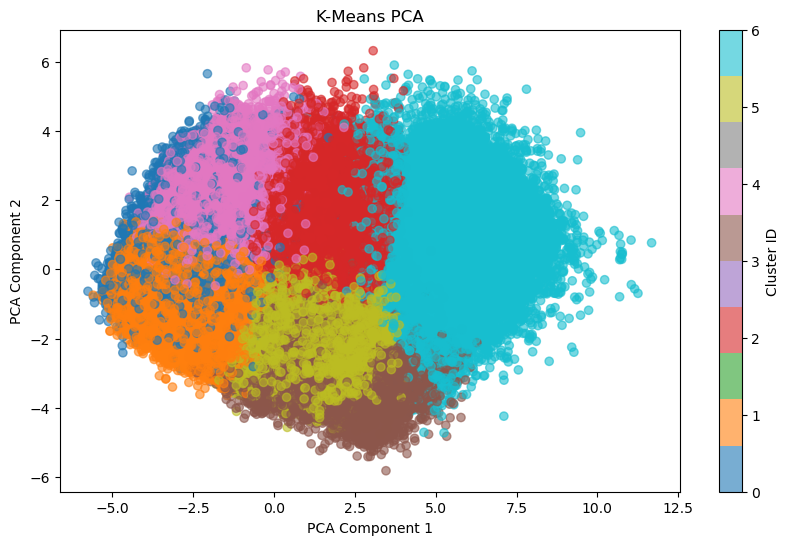

In [44]:
# Reduce dimensions to 2D using PCA for visualization
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X.numpy())  #convert tensor to numpy for PCA

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=df["cluster_pca"], cmap="tab10", alpha=0.6)

plt.colorbar(scatter, label="Cluster ID")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("K-Means PCA")
plt.show()